# Precipitation Seasonal Climatology

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from pathlib import Path

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from plotter import make_cmap
from ar_funcs import preprocess_ar_area_subregions
import nclcmaps as nclc

### Set up paths

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


## Data

### AR time series

In [4]:
# read netCDF with fraction of area AR covers each subregion
filename = path_to_data + 'CH1_generated_data/ar_catalog_ERAI_fraction_HASIAsubregions.nc'
ds = xr.open_dataset(filename)

# Set dates
ds = ds.sel(time=slice('1979-01-01', '2018-12-31'))

## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()


,R01,R02,R03,ar,location
time,,,,,
1979-01-01,0.000000,0.0,0.0,0,NaN
1979-01-02,0.000000,0.0,0.0,0,NaN
1979-01-03,0.005102,0.0,0.0,0,NaN
1979-01-04,0.000000,0.0,0.0,0,NaN
1979-01-05,0.000000,0.0,0.0,0,NaN


### ERA5 reanalysis

In [5]:
# Select lat/lon grid
lonmin = 60
lonmax = 110
latmin = 15
latmax =  50

### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open IVT anomaly data
filepath_pattern = path_to_data + 'ERA5/prec/daily/out.era5*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

# Create new dataset to rename lat lon
era = xr.Dataset({'prec': (['time', 'lat', 'lon'], f1['mtpr'].values*86400)},
                      coords={'time': (['time'], f1.time.values),
                              'lat': (['lat'], f1.latitude.values),
                              'lon': (['lon'], f1.longitude.values)})

era

ds size in GB 1.66



<xarray.Dataset>
Dimensions:  (lat: 141, lon: 201, time: 14610)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T15:00:00 ... 2018-12-31T09:00:00
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 15.75 15.5 15.25 15.0
  * lon      (lon) float32 60.0 60.25 60.5 60.75 ... 109.25 109.5 109.75 110.0
Data variables:
    prec     (time, lat, lon) float64 -8.047e-05 -8.047e-05 ... 17.81 14.17

In [6]:
clim_mean = era.groupby('time.dayofyear').mean('time')
clim_mean.prec.max()

ds_new = xr.Dataset({'precip': (['time', 'lat', 'lon'], clim_mean.prec.values)},
                      coords={'lat': clim_mean.lat,
                        'lon': clim_mean.lon,
                        'time': pd.date_range('1980-01-01', '1980-12-31', freq='D')})

season_prec = ds_new.groupby('time.season').sum(dim='time')
season_prec

<xarray.Dataset>
Dimensions:  (lat: 141, lon: 201, season: 4)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 ... 109.25 109.5 109.75 110.0
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 15.75 15.5 15.25 15.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precip   (season, lat, lon) float64 80.04 80.44 79.46 ... 904.2 826.6 790.6

### IMERG-PM

In [11]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

filename_pattern1 = '/home/sbarc/students/nash/data/IMERGV06B/3B-DAY.MS.MRG.3IMERG.20*.nc4'
ds = xr.open_mfdataset(filename_pattern1, engine='netcdf4', concat_dim='time', combine='by_coords',
                      preprocess=preprocess)

print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds = ds.transpose('lat', 'lon', 'time')
ds

# fname = '/home/sbarc/students/nash/data/IMERGV06B/climatology/filtered_daily_mean_clim_precipitationCal.nc'
# ds = xr.open_dataset(fname, engine='netcdf4')

# print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# ds = ds.transpose('lat', 'lon', 'dayofyear')
# ds

ds size in GB 4.90



,Array,Chunk
Bytes,4.90 GB,700.00 kB
Shape,"(350, 500, 7000)","(350, 500, 1)"
Count,35000 Tasks,7000 Chunks
Type,float32,numpy.ndarray


### Select data subset

In [7]:
# Add AR time series to era5; set as coordinate variables
era['ar'] = ('time', df.ar)
era = era.set_coords('ar')

era['location'] = ('time', df.location)
era = era.set_coords('location')

# print dataset
print(era)

<xarray.Dataset>
Dimensions:   (lat: 141, lon: 201, time: 14610)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T15:00:00 ... 2018-12-31T09:00:00
  * lat       (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 15.75 15.5 15.25 15.0
  * lon       (lon) float32 60.0 60.25 60.5 60.75 ... 109.25 109.5 109.75 110.0
    ar        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location  (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    prec      (time, lat, lon) float64 -8.047e-05 -8.047e-05 ... 17.81 14.17


In [8]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select DJF months
idx = (era.time.dt.month >= 12) | (era.time.dt.month <= 2)
era = era.sel(time=idx)

# Select AR days
idx = (era.ar >= 1)
era_ar = era.sel(time=idx)

# print results
print(era_ar)

<xarray.Dataset>
Dimensions:   (lat: 141, lon: 201, time: 371)
Coordinates:
  * time      (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat       (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 15.75 15.5 15.25 15.0
  * lon       (lon) float32 60.0 60.25 60.5 60.75 ... 109.25 109.5 109.75 110.0
    ar        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'R03' 'R01' 'R01' 'R01' ... 'R03' 'R02' 'R01' 'R01'
Data variables:
    prec      (time, lat, lon) float64 0.5169 0.5385 0.4739 ... 3.539 4.4 2.546


In [9]:
era

<xarray.Dataset>
Dimensions:   (lat: 141, lon: 201, time: 3520)
Coordinates:
  * time      (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-28T09:00:00
  * lat       (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 15.75 15.5 15.25 15.0
  * lon       (lon) float32 60.0 60.25 60.5 60.75 ... 109.25 109.5 109.75 110.0
    ar        (time) int64 1 1 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 1 0 0
    location  (time) object 'R03' 'R01' nan nan nan ... nan nan 'R01' nan nan
Data variables:
    prec      (time, lat, lon) float64 0.5169 0.5385 0.4739 ... 0.2247 0.09362

## Calculate climatology

In [32]:
# calculate seasonal totals
era_ssn_sum = era.resample(time='QS-DEC').sum()
era_ar_ssn_sum = era_ar.resample(time='QS-DEC').sum()                                 
# calculate average of seasonal totals
era_clim = era_ssn_sum.mean(dim='time')
era_ar_clim = era_ar_ssn_sum.mean(dim='time') 

# Mean prec of AR days in DJF
era_ar_clim_day = era_ar.mean(dim='time')
era_clim_day = era.mean(dim='time')


## Create figure

In [37]:
# Data for plotting
lons = era_clim.lon.values
lats = era_clim.lat.values
# data = [era_clim.prec.values, season_prec.precip.sel(season='DJF').values, era_ar_clim.prec.values]
prec_frac = (era_ar_clim.prec.values/era_clim.prec.values)*100.
std_dev_ar = era_ar_ssn_sum.std(dim='time')
data = [era_clim.prec.values, prec_frac, std_dev_ar.prec.values]
print(data[0].min(), data[0].max(), data[0].mean())
print(data[2].min(), data[2].max(), data[2].mean())
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# # set seaborn style
# sns.set()
# sns.set_style("ticks", {'patch.force_edgecolor':False})
plt_labels = ['Avg DJF Prec Totals', 'Avg DJF Prec Totals - comp', 'Avg DJF AR Prec Totals']
plt_labels = ['Avg DJF Prec Totals', 'AR Fraction of DJF Prec', 'Std. Dev. of AR DJF Prec']

1.0505201724859385 2274.7865916444707 62.424101297350205
0.18917606413837804 121.43964662659164 12.08181519946709


In [38]:
# clevs = np.arange(100., 2600., 100)
clevs = np.arange(25., 650., 25)
clevs

cmap_data = [
             (30, 60, 255), # dark blue 100-200
             (0, 160, 255), # light blue 200-300
             (0, 200, 200), # lighter blue 300-400
             (0, 210, 140), # teal 400-500
             (0, 220, 0), # green 500-600
             (160, 230, 50), #light green 600-700
             (160, 230, 50), #light green 700-800
             (230, 220, 50), # yellow 800-900
             (230, 220, 50), # yellow 900-1000
             (230, 175, 45), # light orange 1000-1100
             (230, 175, 45), # light orange 1100-1200
             (230, 175, 45), # light orange 1200-1300
             (230, 175, 45), # light orange 1300-1400
             (230, 175, 45), # light orange 1400-1500
             (240, 130, 40), # dark orange 1500-1600
             (240, 130, 40), # dark orange 1600-1700
             (240, 130, 40), # dark orange 1700-1800
             (240, 130, 40), # dark orange 1800-1900
             (240, 130, 40), # dark orange 1900-2000
             (250, 60, 60), # light red 2000-2100
             (250, 60, 60), # light red 2100-2200
             (250, 60, 60), # light red 2200-2300
             (250, 60, 60), # light red 2300-2400
             (250, 60, 60) # light red 2400-2500
#              (240, 0, 130)
            ]

my_cmap = make_cmap(cmap_data, bit=True)

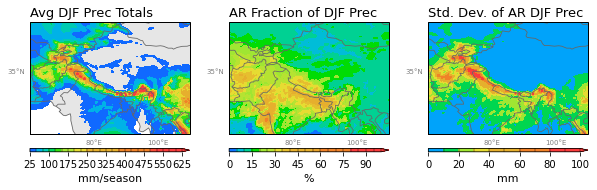

In [40]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = len(data)

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='each',
                cbar_pad=0.2, cbar_size='3%',label_mode='')

# cmap = nclc.cmap('WhiteBlueGreenYellowRed')
cmap=my_cmap

clevs_list = [clevs, np.arange(0,105,5), np.arange(0,110,10)]
cbar_label = ['mm/season', '%', 'mm']

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
#     clevs = np.arange(2,252,25)
    cf = ax.contourf(lons, lats, data[k], transform=datacrs,
                    levels=clevs_list[k],cmap=cmap, extend='max')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

    
    # Colorbar (each)
    cb = fig.colorbar(cf, axgr.cbar_axes[k], orientation='horizontal', drawedges=True)
    cb.set_label(cbar_label[k], fontsize=11)
    cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'prec_clim_djf' + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()

In [34]:
# Data for plotting
lons = era_clim.lon.values
lats = era_clim.lat.values

prec_frac = (era_ar_clim_day.prec.values/era_clim_day.prec.values)*100.
std_dev_ar = era_ar.std(dim='time')
data = [era_clim_day.prec.values, era_ar_clim_day.prec.values, std_dev_ar.prec.values]
for i in range(len(data)):
    print(data[i].min(), data[i].max(), data[i].mean())

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# # set seaborn style
# sns.set()
# sns.set_style("ticks", {'patch.force_edgecolor':False})
plt_labels = ['Avg DJF Prec Avg', 'AR Fraction of DJF Prec', 'Std. Dev. of AR DJF Prec']

0.011639286001974886 25.203601441515442 0.6916306677831413
0.012030466547552144 20.79489068040308 1.2119994640336467
0.05496880310858506 22.78597024390072 2.9176629061619743


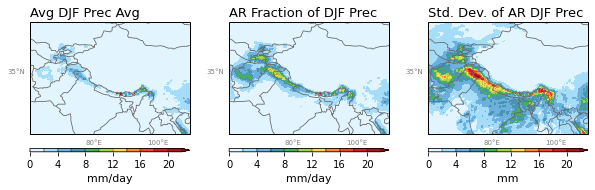

In [36]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = len(data)

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='each',
                cbar_pad=0.2, cbar_size='3%',label_mode='')

cmap = nclc.cmap('WhiteBlueGreenYellowRed')
# cmap=my_cmap

clevs_list = [np.arange(0,24,2), np.arange(0,24,2), np.arange(0,24,2)]
cbar_label = ['mm/day', 'mm/day', 'mm']

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Precip (filled contour)
#     clevs = np.arange(2,252,25)
    cf = ax.contourf(lons, lats, data[k], transform=datacrs,
                    levels=clevs_list[k],cmap=cmap, extend='max')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

    
    # Colorbar (each)
    cb = fig.colorbar(cf, axgr.cbar_axes[k], orientation='horizontal', drawedges=True)
    cb.set_label(cbar_label[k], fontsize=11)
    cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'prec_clim_djf_daily' + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()

In [ ]:
# Create figure
fig = plt.figure(figsize=(6,6))

# Add plot axes and draw basemap
ax = fig.add_subplot(111, projection=mapcrs)
#ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

# prec (filled contour)
clevs = np.arange(2,22,2)
cf = ax.contourf(lons, lats, data, transform=datacrs, extend='max',
                levels=clevs, cmap=cmo.rain)


# Colorbar 
cb = fig.colorbar(cf, orientation='horizontal', drawedges=True, pad=0.04, aspect=25)
cb.set_label('prec (mm day$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)

# Title
ax.set_title('Precipitation (Dec-Feb 1979-2018)', loc='center', fontsize=13)

# show figure
filepath = path_to_figs + 'prec_clim_djf' + '.png'
plt.savefig(filepath, bbox_inches='tight', dpi=200)
plt.show()


In [ ]:
# Data for plotting
lons = era_ar_clim.lon.values
lats = era_ar_clim.lat.values
data = era_ar_clim.prec.values
print(data.min(), data.max())

In [ ]:
# Create figure
fig = plt.figure(figsize=(6,6))

# Add plot axes and draw basemap
ax = fig.add_subplot(111, projection=mapcrs)
#ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)

# prec (filled contour)
clevs = np.arange(2,22,2)
cf = ax.contourf(lons, lats, data, transform=datacrs, extend='max',
                levels=clevs, cmap=cmo.rain)


# Colorbar 
cb = fig.colorbar(cf, orientation='horizontal', drawedges=True, pad=0.04, aspect=25)
cb.set_label('prec (mm day$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)

# Title
ax.set_title('AR Days (Dec-Feb 1979-2018)', loc='center', fontsize=13)

# show figure
filepath = path_to_figs + 'prec_ar_clim_djf' + '.png'
plt.savefig(filepath, bbox_inches='tight', dpi=200)
plt.show()
